In [5]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import geopandas as gpd

In [6]:
noised_isd = pd.read_csv("irving_blocks/noised_isd.csv")
noised_city = pd.read_csv("irving_blocks/noised_city.csv")

In [7]:
noised_isd_pct = noised_isd.groupby(["PCT08_NM", 
                                     "epsilon", 
                                     "split"]).sum()[["HVAP10", "VAP10", 'IR06ISD3ST', 'IR06ISD3BE', 
                                                      'IR06ISD4JO', 'IR06ISD4CA', 'IR08ISD1PO', 
                                                      'IR08ISD1BA', 'IR08ISD1JO', 'IR08ISD2JE',
                                                      'IR08ISD2CH', 'CVAP09', 'HCVAP09','CVAP00', 'HCVAP00'] 
                                     + [col for col in noised_isd.columns if 'noise' in col]].reset_index()
noised_city_pct = noised_city.groupby(["PCT08_NM", 
                                       "epsilon", 
                                       "split"]).sum()[['IR05CC5CAN','IR05CC5MED', 'IR05CC5COL', 
                                                        'IR08MAYGEA', 'IR08MAYJET', 'IR08MAYREZ',
                                                        'IR08CC3MEA', 'IR08CC3RIV',"HVAP10", "VAP10", 
                                                        'CVAP09', 'HCVAP09', 'CVAP00', 'HCVAP00']
                                       + [col for col in noised_city.columns if 'noise' in col]].reset_index()

In [8]:
def plot_er_graph(data, cand, elect, cand_col, elect_cols, eps, split,
                  filt=True, n_samps=32, ax=None, title=True, plot_cvap=False):
    
    df = data.query("epsilon == @eps & split == @split")
    df = df.query(" | ".join(["{} != 0".format(c) for c in elect_cols])) if filt else df
    xp = np.linspace(0, 1, 100)
    perc_hvap = (df.HVAP10 / df.VAP10).fillna(0)
    perc_cand = (df[cand_col] / sum([df[c] for c in elect_cols])).fillna(0)
    line = sp.stats.linregress(perc_hvap, perc_cand)
    l = np.poly1d([line.slope, line.intercept])

    ms = np.zeros(n_samps)

    if ax==None:
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(1, 1, 1)
    if title: ax.set_title("ER - Votes for {}: {}".format(cand, elect))
    ax.set_xlim(-0.05,1.05)
    ax.set_ylim(-0.05,1.05)

    for i in range(n_samps):
        perc_hvap_noised = (df["{}_HVAP_noise".format(i)] / df["{}_VAP_noise".format(i)]).fillna(0)
            
        line_noised = sp.stats.linregress(perc_hvap_noised, perc_cand)
        ln = np.poly1d([line_noised.slope, line_noised.intercept])
        ms[i] = line_noised.slope
        ax.plot(perc_hvap_noised, perc_cand, '.', color="lightcoral")
        ax.plot(xp, ln(xp), '-', color="lightcoral")
        
    if plot_cvap:
        perc_hcvap = (df.HCVAP09 / df.CVAP09).fillna(0)
        line_cvap = sp.stats.linregress(perc_hcvap, perc_cand)
        l_cvap = np.poly1d([line_cvap.slope, line_cvap.intercept])
        ax.plot(perc_hcvap, perc_cand, '.', color="grey")
        ax.plot(xp, l_cvap(xp), linestyle="dashed", color="grey", 
                label="HCVAP09 | m: {}".format(round(line_cvap.slope, 3)))
        
        perc_hcvap = (df.HCVAP00 / df.CVAP00).fillna(0)
        line_cvap = sp.stats.linregress(perc_hcvap, perc_cand)
        l_cvap = np.poly1d([line_cvap.slope, line_cvap.intercept])
        ax.plot(perc_hcvap, perc_cand, '.', color="k")
        ax.plot(xp, l_cvap(xp), linestyle="dashed", color="k", 
                label="HCVAP00 | m: {}".format(round(line_cvap.slope, 3)))
    
    ax.plot(perc_hvap, perc_cand, '.', color="b")
    ax.plot(xp, l(xp), '-', color="b", 
             label="m: {}".format(round(line.slope, 3)))
    ax.plot([], [], '-', color="r", 
             label="E(m): {}, Var(m): {}".format(round(np.mean(ms),3), round(np.var(ms),4)))  
    
    ax.legend()
    ax.set_xlabel("% HVAP")
    ax.set_ylabel("{} % of Voters".format(cand))
    return ax

In [9]:
def plot_elect_grid(epsilon_values, epsilon_splits, data, candidate, election, 
                    candidate_col, election_cols, figsize=(10,10), filt=True, title=True):
    
    fig, axs = plt.subplots(len(epsilon_values),len(epsilon_splits), figsize=figsize)

    if title: fig.suptitle("ER - Votes for {}: {}".format(candidate, election))
    plt.subplots_adjust(hspace = 0.25)

    for i in range(len(epsilon_values)):
        for j in range(len(epsilon_splits)):
            plot_er_graph(data, candidate, election, candidate_col, election_cols, 
                          epsilon_values[i], epsilon_splits[j], title=False, ax=axs[i,j], filt=filt)

    pad = 5
    for ax, row in zip(axs[:,0], ["$\epsilon$ = {}".format(eps) for eps in epsilon_values]):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center')

    for ax, col in zip(axs[0], ["Split: {}".format(s) for s in epsilon_splits]):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, ax.xaxis.labelpad + pad),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline')
        
    return fig, axs

In [151]:
def plot_point_estimates(data, cand, elect, cand_col, elect_cols, eps, split,
                         filt=True, n_samps=32, ax=None, title=True, x_lims=None):
    
    df = data.query("epsilon == @eps & split == @split")
    df = df.query(" | ".join(["{} != 0".format(c) for c in elect_cols])) if filt else df
    xp = np.linspace(0, 1, 100)
    perc_hvap = (df.HVAP10 / df.VAP10).fillna(0)
    perc_cand = (df[cand_col] / sum([df[c] for c in elect_cols])).fillna(0)
    line = sp.stats.linregress(perc_hvap, perc_cand)
    l = np.poly1d([line.slope, line.intercept])

    ms = np.zeros(n_samps)
    zeros = np.zeros(n_samps)
    ones = np.zeros(n_samps)

    if ax==None:
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(1, 1, 1)
    if title: ax.set_title("ER Point Estimates - Votes for {}: {}".format(cand, elect))

    if x_lims: ax.set_xlim(x_lims[0],x_lims[1])

    for i in range(n_samps):
        perc_hvap_noised = (df["{}_HVAP_noise".format(i)] / df["{}_VAP_noise".format(i)]).fillna(0)
            
        line_noised = sp.stats.linregress(perc_hvap_noised, perc_cand)
        ln = np.poly1d([line_noised.slope, line_noised.intercept])
        ms[i] = line_noised.slope
        zeros[i] = line_noised.intercept
        ones[i] = ln(1)
    
    ax.hist(zeros, color="limegreen", alpha=0.5, label="all but HVAP support")
    ax.hist(ones, color="mediumpurple",  alpha=0.5, label="HVAP support")
    ax.axvline(zeros.mean(), color="limegreen")
    ax.axvline(ones.mean(), color="mediumpurple")
    ax.axvline(l(0), color="slategrey", linestyle="dashed")
    ax.axvline(l(1), color="slategrey", linestyle="dashed", label="un-noised data")
        
    ax.legend(loc="upper center")
    ax.set_xlabel("Support for {}".format(cand))
    return ax

In [152]:
def plot_point_estimate_grid(epsilon_values, epsilon_splits, data, candidate, election, 
                             candidate_col, election_cols, figsize=(10,10), 
                             filt=True, title=True, x_lims=None):
    
    fig, axs = plt.subplots(len(epsilon_values),len(epsilon_splits), figsize=figsize)

    if title: fig.suptitle("ER - Votes for {}: {}".format(candidate, election))
    plt.subplots_adjust(hspace = 0.25)

    for i in range(len(epsilon_values)):
        for j in range(len(epsilon_splits)):
            plot_point_estimates(data, candidate, election, candidate_col, 
                                 election_cols, epsilon_values[i], epsilon_splits[j], 
                                 title=False, ax=axs[i,j], filt=filt, x_lims=x_lims)

    pad = 5
    for ax, row in zip(axs[:,0], ["$\epsilon$ = {}".format(eps) for eps in epsilon_values]):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center')

    for ax, col in zip(axs[0], ["Split: {}".format(s) for s in epsilon_splits]):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, ax.xaxis.labelpad + pad),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline')
        
    return fig, axs

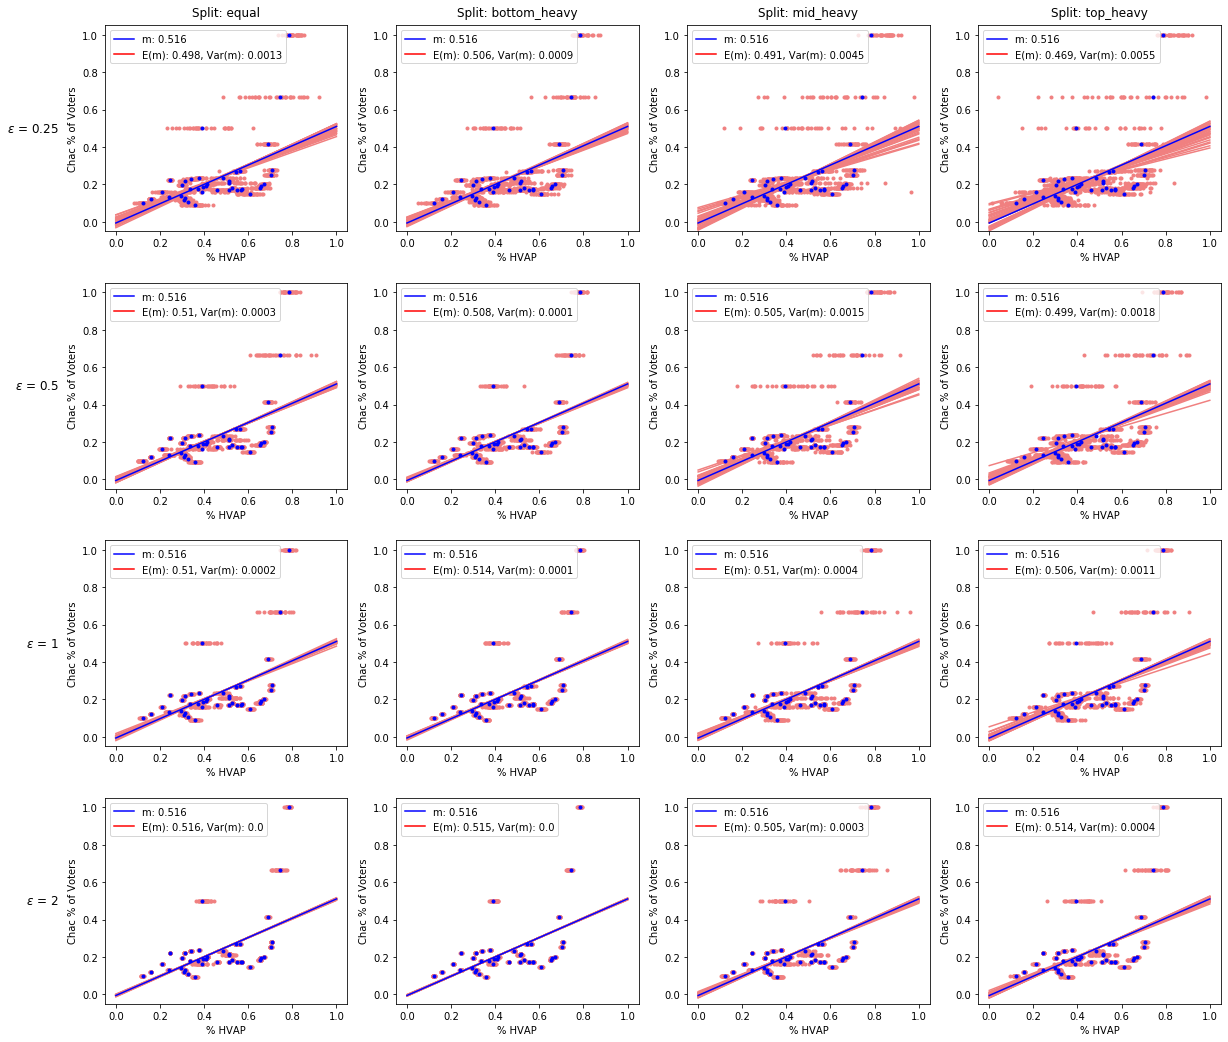

In [153]:
epsilon_values = [0.25, 0.5, 1, 2]
epsilon_splits = ["equal","bottom_heavy", "mid_heavy", "top_heavy",]
data = noised_isd_pct
candidate = "Chac"
election = "ISD Place 2, 2008"
candidate_col = "IR08ISD2CH"
election_cols = ["IR08ISD2CH", "IR08ISD2JE"]

fig, axs = plot_elect_grid(epsilon_values, epsilon_splits, data, candidate, election, 
                           candidate_col, election_cols, figsize=(20,18), title=False)
plt.savefig("plots/ER_{}_{}_elect_param_grid.png".format(candidate, election.replace(',', "").replace(' ', '_')),
            dpi=200, bbox_inches="tight")

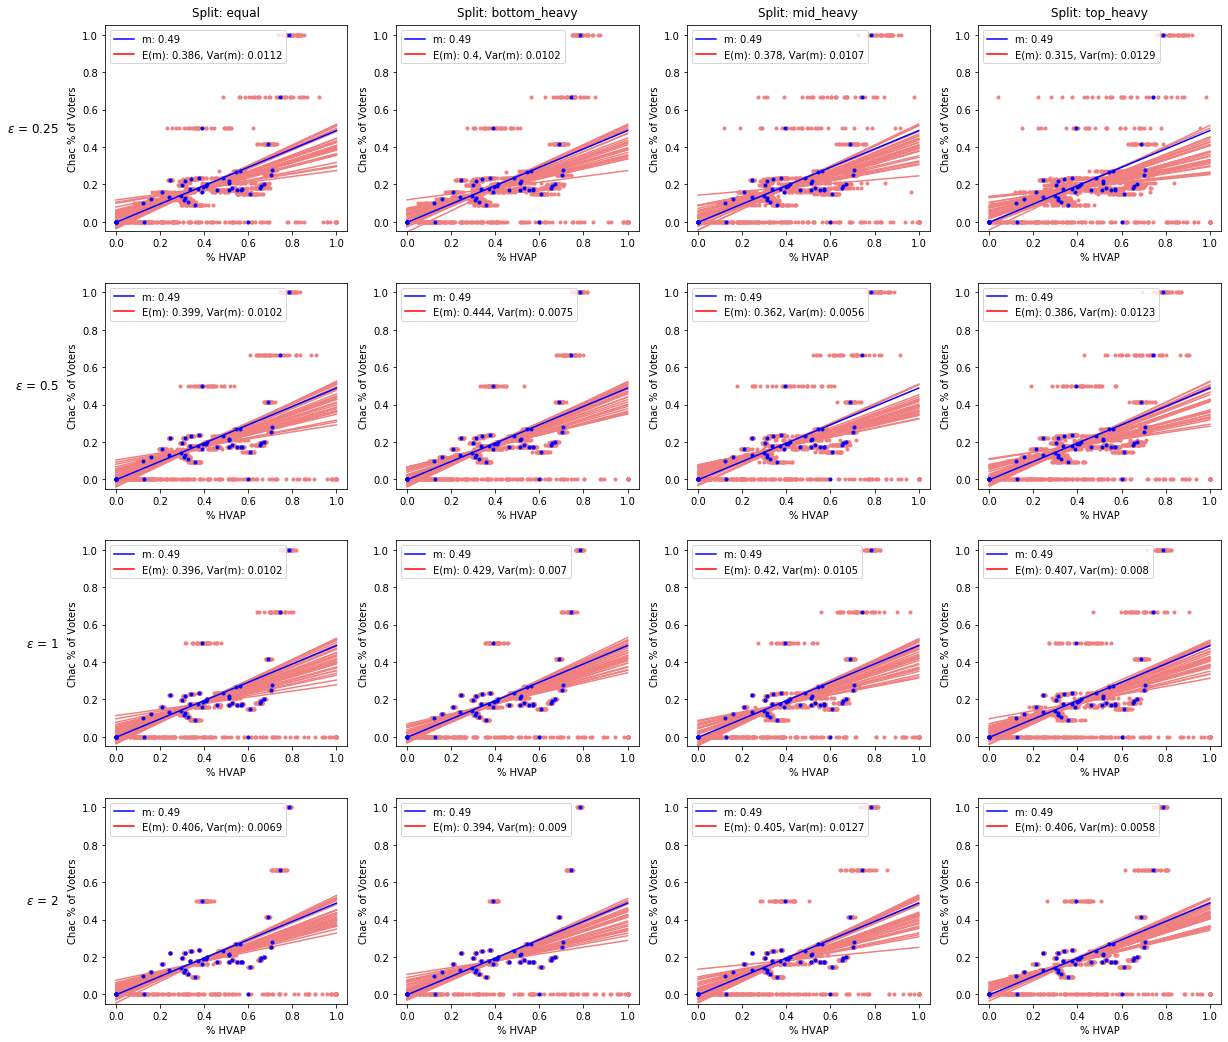

In [154]:
fig, axs = plot_elect_grid(epsilon_values, epsilon_splits, data, candidate, election, 
                           candidate_col, election_cols, figsize=(20,18), filt=False, title=False)
plt.savefig("plots/ER_{}_{}_elect_param_grid_no_filt.png".format(candidate, election.replace(',', "").replace(' ', '_')),
            dpi=200, bbox_inches="tight")

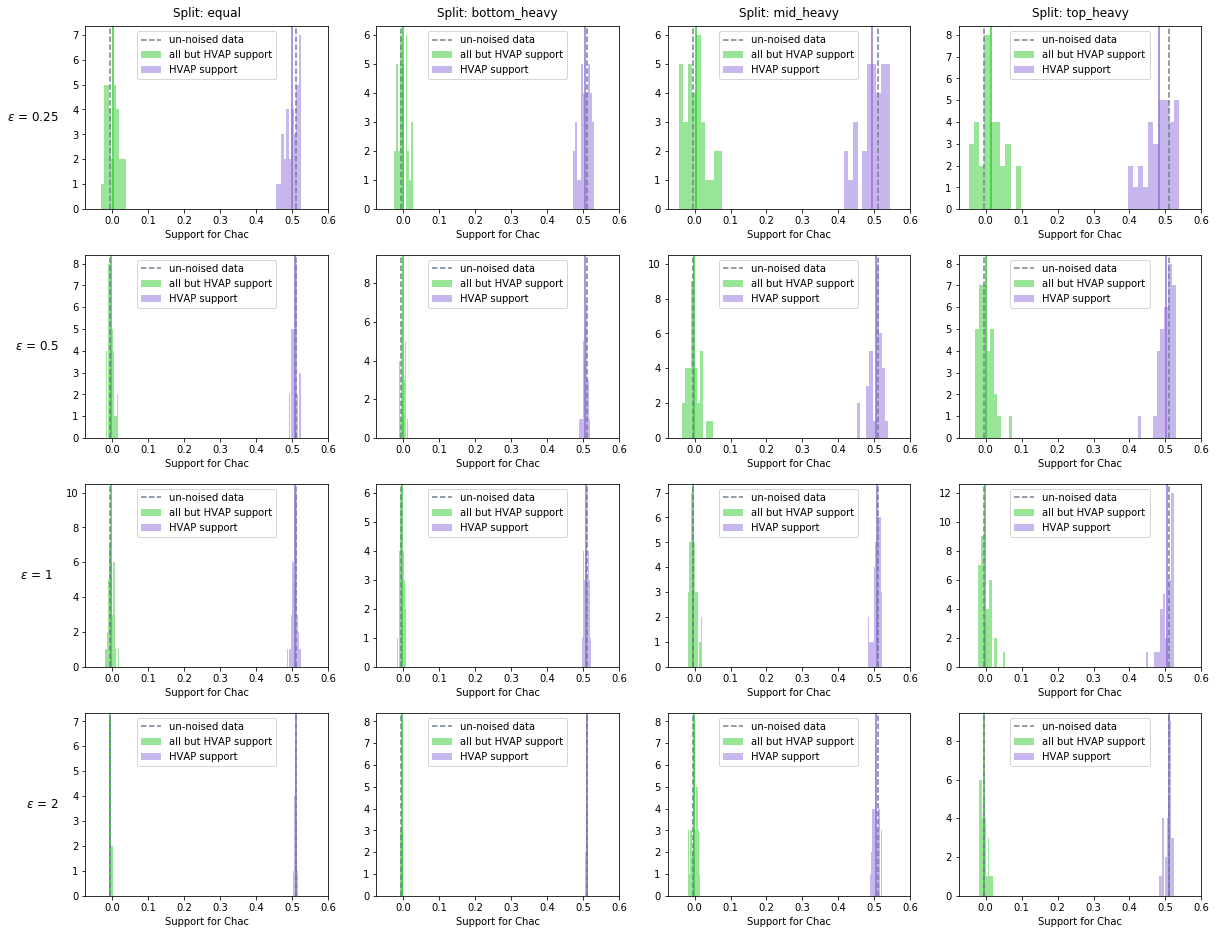

In [155]:
fig, axs = plot_point_estimate_grid(epsilon_values, epsilon_splits, data, 
                                    candidate, election, candidate_col, election_cols, 
                                    figsize=(20,16), title=False, x_lims=[-0.075, 0.6])
plt.savefig("plots/ER_{}_{}_elect_param_grid_points.png".format(candidate, 
                                                                election.replace(',', "").replace(' ', '_')),
            dpi=200, bbox_inches="tight")

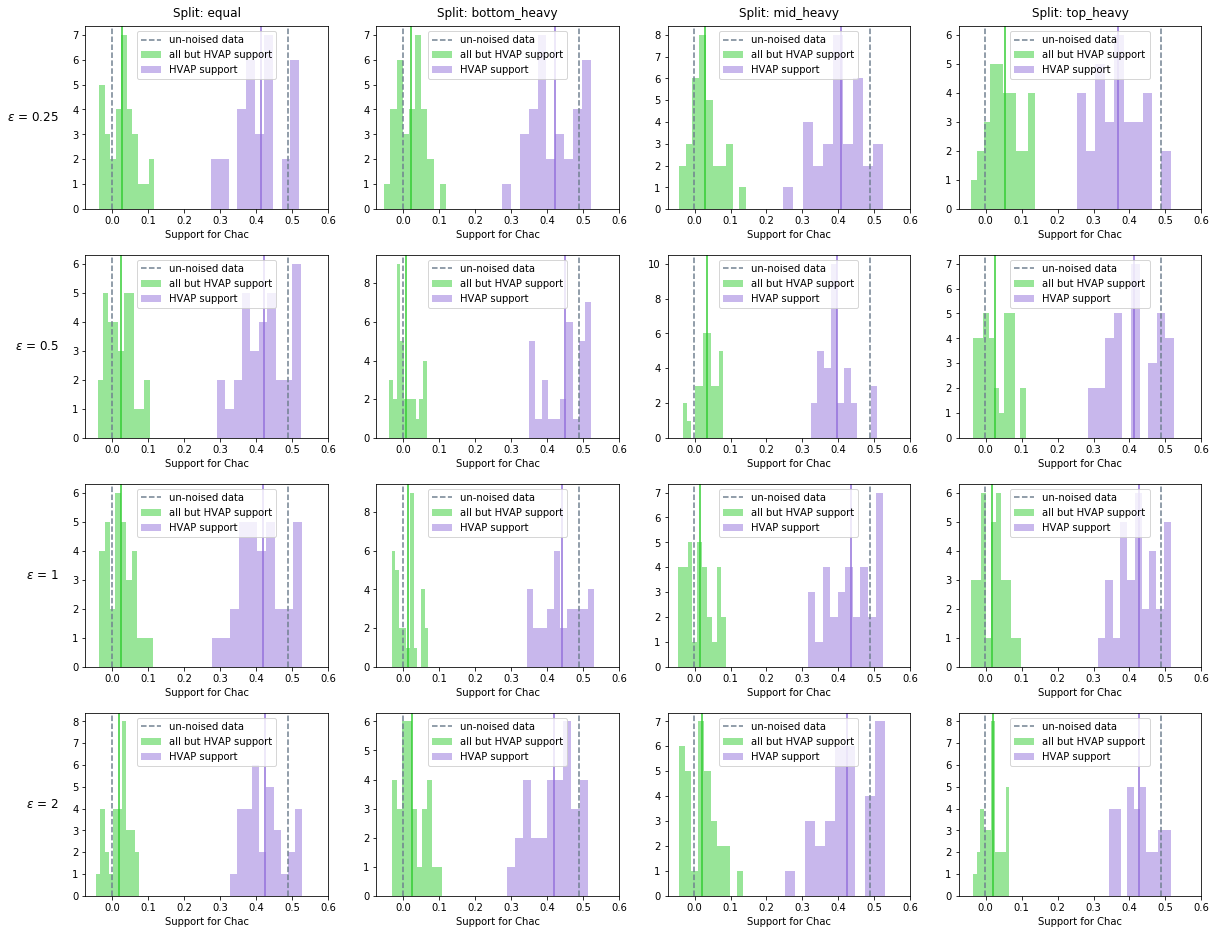

In [156]:
fig, axs = plot_point_estimate_grid(epsilon_values, epsilon_splits, data, 
                                    candidate, election, candidate_col, election_cols, 
                                    figsize=(20,16), title=False, x_lims=[-0.075, 0.6], 
                                    filt=False)
plt.savefig("plots/ER_{}_{}_elect_param_grid_points_no_filt.png".format(candidate, 
                                                                election.replace(',', "").replace(' ', '_')),
            dpi=200, bbox_inches="tight")

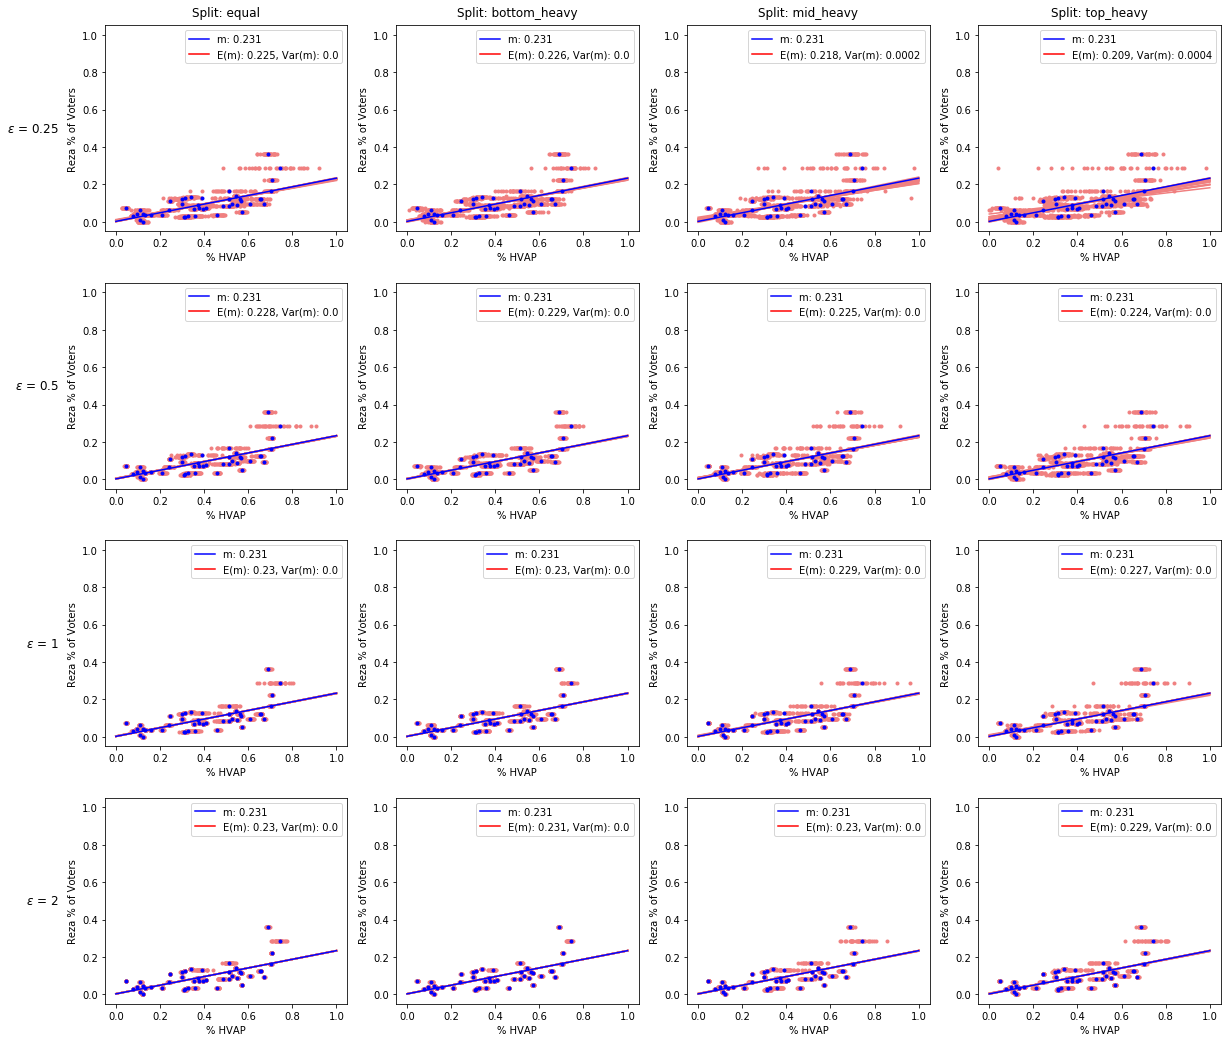

In [157]:
epsilon_values = [0.25, 0.5, 1, 2]
epsilon_splits = ["equal","bottom_heavy", "mid_heavy", "top_heavy",]
data = noised_city_pct
candidate = "Reza"
election = "Mayor 2008"
candidate_col = "IR08MAYREZ"
election_cols = ["IR08MAYREZ", "IR08MAYGEA", "IR08MAYJET"]

fig, axs = plot_elect_grid(epsilon_values, epsilon_splits, data, candidate, election, 
                           candidate_col, election_cols, figsize=(20,18), title=False)
plt.savefig("plots/ER_{}_{}_elect_param_grid.png".format(candidate, election.replace(',', "").replace(' ', '_')),
            dpi=200, bbox_inches="tight")

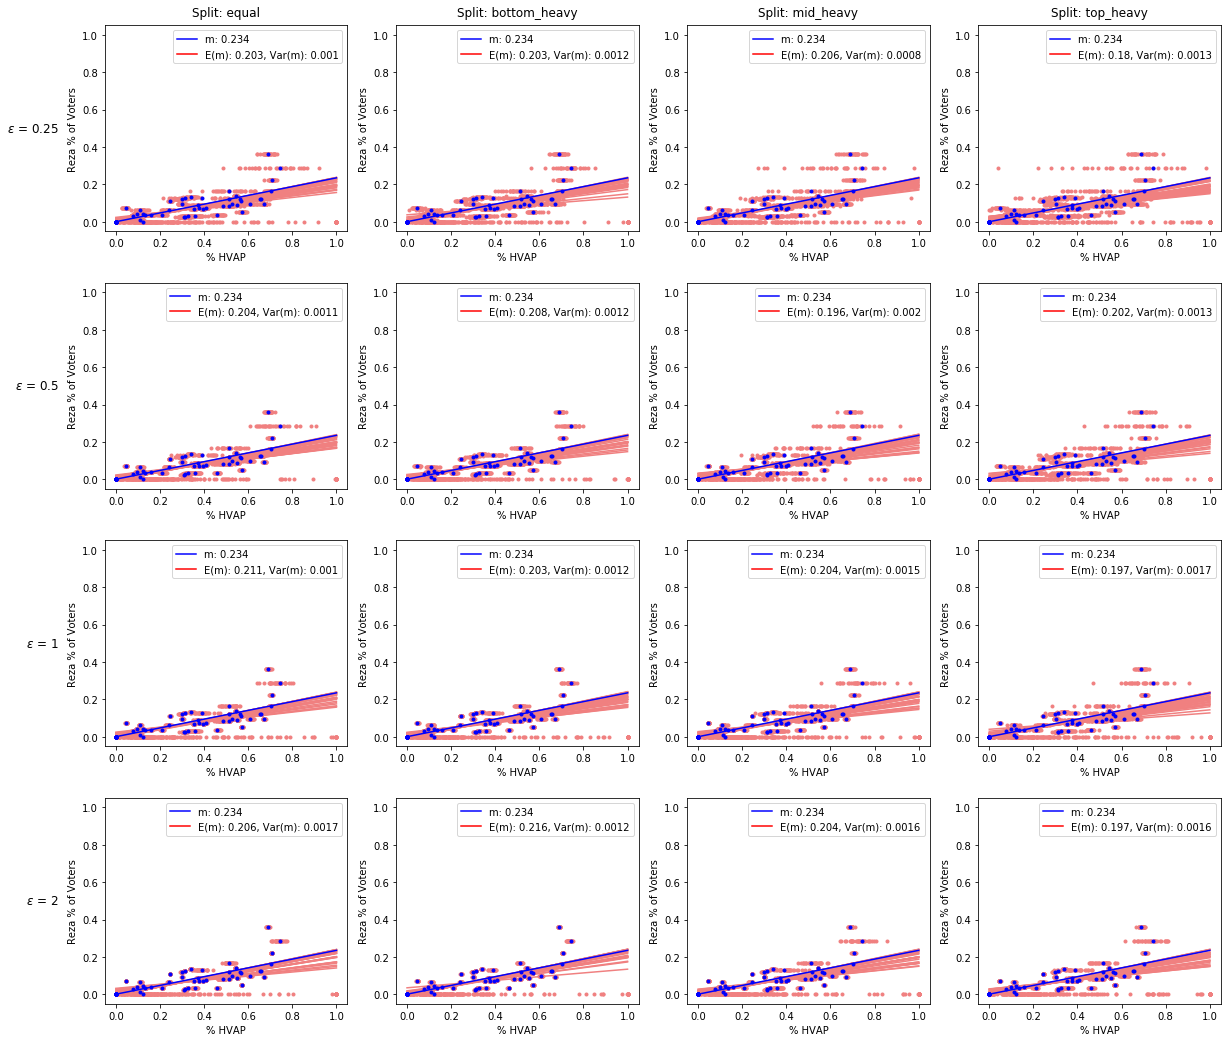

In [158]:
fig, axs = plot_elect_grid(epsilon_values, epsilon_splits, data, candidate, election, 
                           candidate_col, election_cols, figsize=(20,18), filt=False, title=False)
plt.savefig("plots/ER_{}_{}_elect_param_grid_no_filt.png".format(candidate, election.replace(',', "").replace(' ', '_')),
            dpi=200, bbox_inches="tight")

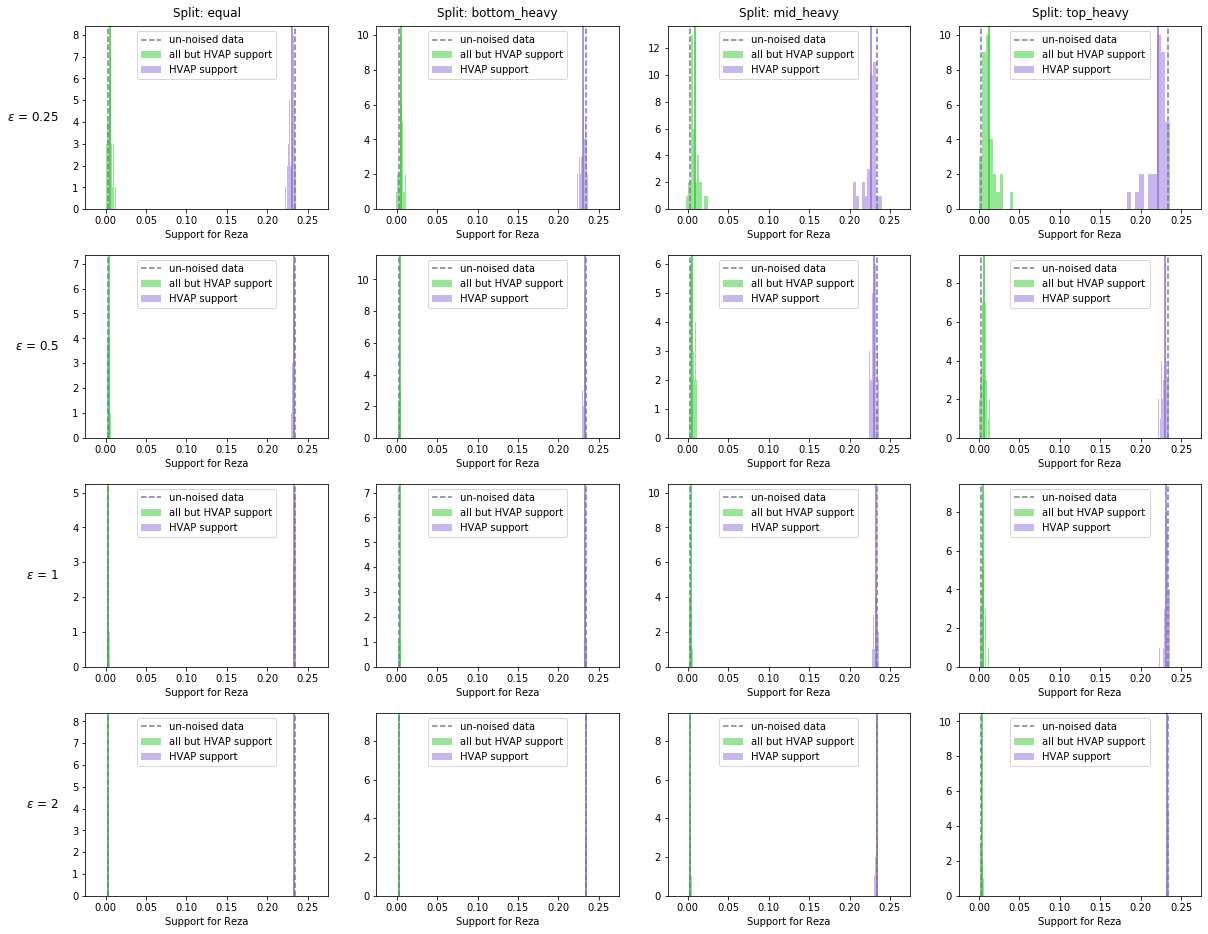

In [159]:
fig, axs = plot_point_estimate_grid(epsilon_values, epsilon_splits, data, 
                                    candidate, election, candidate_col, election_cols, 
                                    figsize=(20,16), title=False, x_lims=[-0.025, 0.275])
plt.savefig("plots/ER_{}_{}_elect_param_grid_points.png".format(candidate, 
                                                                election.replace(',', "").replace(' ', '_')),
            dpi=200, bbox_inches="tight")

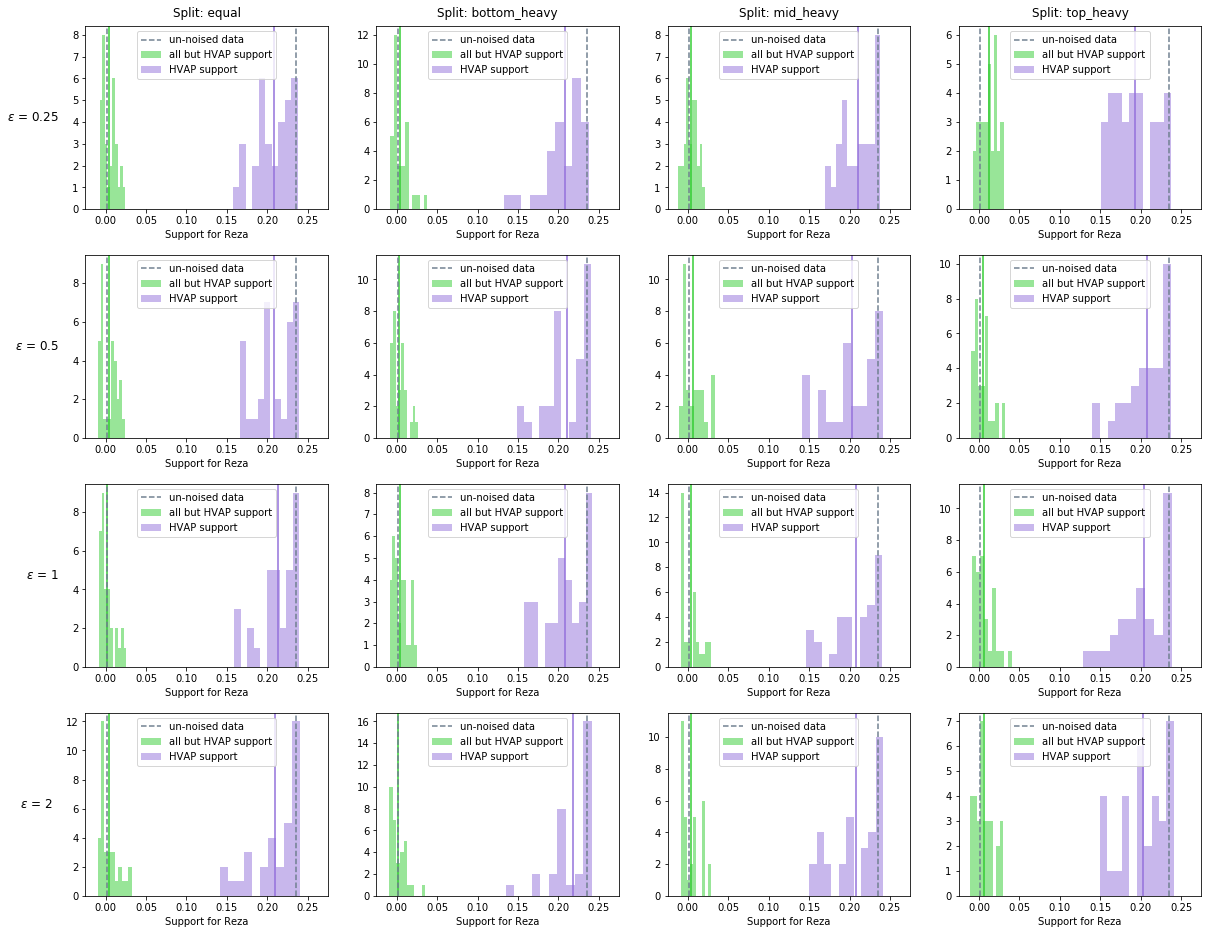

In [160]:
fig, axs = plot_point_estimate_grid(epsilon_values, epsilon_splits, data, 
                                    candidate, election, candidate_col, election_cols, 
                                    figsize=(20,16), title=False, x_lims=[-0.025, 0.275], 
                                    filt=False)
plt.savefig("plots/ER_{}_{}_elect_param_grid_points_no_filt.png".format(candidate, 
                                                                election.replace(',', "").replace(' ', '_')),
            dpi=200, bbox_inches="tight")

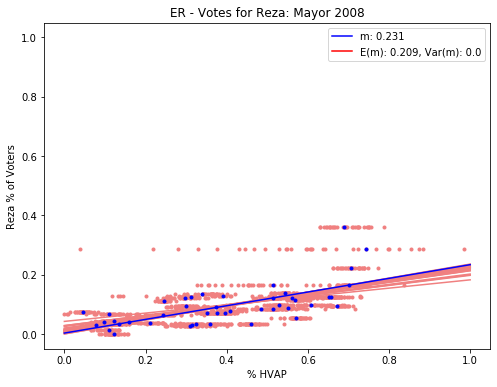

In [8]:
fig = plot_er_graph(noised_city_pct, "Reza", "Mayor 2008", "IR08MAYREZ", 
                    ["IR08MAYREZ", "IR08MAYGEA", "IR08MAYJET"], 0.25, "top_heavy", plot_cvap=False)
# plt.savefig("plots/ER_Reza_Mayor_2008_display_cvap.png")

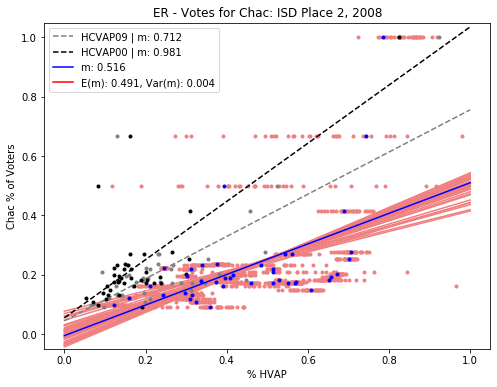

In [27]:
fig = plot_er_graph(noised_isd_pct, "Chac", "ISD Place 2, 2008", "IR08ISD2CH", 
                    ["IR08ISD2CH", "IR08ISD2JE"], 0.25, "mid_heavy", plot_cvap=True)
# plt.savefig("plots/ER_Chac_ISD_Pl2_2008_var.png")

In [50]:
noised_hvap_error_pct.shape

(32, 49)

In [49]:
noised_hvap_error_blocks.shape

(32, 2294)

In [57]:
eps = 0.25
split = "top_heavy"
data = noised_isd_pct.query("epsilon == @eps & split == @split")
noised_hvap_error_pct = np.array([data["HVAP10"]  - data["{}_HVAP_noise".format(i)] for i in range(32)])
data = noised_isd.query("epsilon == @eps & split == @split")
noised_hvap_error_blocks = np.array([data["HVAP10"]  - data["{}_HVAP_noise".format(i)] for i in range(32)])

In [58]:
# noised_hvap_error_blocks = np.array([noised_isd["HVAP10"]  - noised_isd["{}_HVAP_noise".format(i)] for i in range(32)])

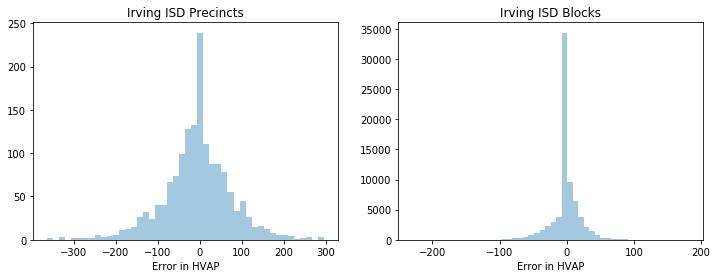

In [59]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
sns.distplot(noised_hvap_error_pct.flatten(), kde=False, ax=axs[0])
sns.distplot(noised_hvap_error_blocks.flatten(), kde=False, ax=axs[1])

axs[0].set_title("Irving ISD Precincts")
axs[1].set_title("Irving ISD Blocks")

axs[0].set_xlabel("Error in HVAP")
axs[1].set_xlabel("Error in HVAP")

plt.show()

In [60]:
data = noised_isd_pct.query("epsilon == @eps & split == @split")

In [66]:
data[['HVAP10', 'VAP10']].values

array([[ 100,  255],
       [ 565,  719],
       [   0,    0],
       [   0,    0],
       [   0,    0],
       [ 849, 2049],
       [   3,    5],
       [ 855, 2840],
       [2104, 5306],
       [2353, 4269],
       [ 118,  159],
       [2326, 4517],
       [1527, 3746],
       [2896, 5480],
       [3168, 4509],
       [ 925, 1649],
       [1601, 4770],
       [2903, 5099],
       [2147, 4183],
       [2185, 3331],
       [1895, 3317],
       [1374, 1995],
       [ 422, 1131],
       [2366, 3352],
       [  92,  236],
       [ 722, 1186],
       [ 522, 1607],
       [3784, 5637],
       [   0,    0],
       [1736, 5572],
       [ 841, 2476],
       [2077, 3827],
       [1351, 2934],
       [1007, 3209],
       [ 540, 1739],
       [1139, 7196],
       [   0,    0],
       [1982, 8095],
       [2516, 6680],
       [ 414, 1972],
       [ 366, 1511],
       [ 584, 1969],
       [ 160, 1316],
       [  29,  230],
       [   0,    0],
       [1029, 1580],
       [ 244,  680],
       [ 382,

In [7]:
list(noised_isd.columns)

['STATEFP10',
 'COUNTYFP10',
 'TRACTCE10',
 'BLOCKCE10',
 'GEOID10',
 'NAME10',
 'MTFCC10',
 'UR10',
 'UACE10',
 'FUNCSTAT10',
 'ALAND10',
 'AWATER10',
 'INTPTLAT10',
 'INTPTLON10',
 'TOTPOP10',
 'NH_WHITE10',
 'NH_BLACK10',
 'NH_AMIN10',
 'NH_ASIAN10',
 'NH_NHPI10',
 'NH_OTHER10',
 'NH_2MORE10',
 'HISP10',
 'H_WHITE10',
 'H_BLACK10',
 'H_AMIN10',
 'H_ASIAN10',
 'H_NHPI10',
 'H_OTHER10',
 'H_2MORE10',
 'VAP10',
 'HVAP10',
 'WVAP10',
 'BVAP10',
 'AMINVAP10',
 'ASIANVAP10',
 'NHPIVAP10',
 'OTHERVAP10',
 '2MOREVAP10',
 'NAME',
 'state',
 'county',
 'tract',
 'block',
 'geoid',
 'HCVAP09',
 'NHCVAP09',
 'AMNCVAP09',
 'ACVAP09',
 'BCVAP09',
 'HPICVAP09',
 'WCVAP09',
 'CVAP09',
 'HCVAP09M',
 'NHCVAP09M',
 'AMNCVAP09M',
 'ACVAP09M',
 'BCVAP09M',
 'HPICVAP09M',
 'WCVAP09M',
 'CVAP09M',
 'HCPOP00',
 'WCPOP00',
 'BCPOP00',
 'ACPOP00',
 'OTHRCPOP00',
 '2MORCPOP00',
 'HCVAP00',
 'WCVAP00',
 'BCVAP00',
 'ACVAP00',
 'OTHRCVAP00',
 '2MORCVAP00',
 'CPOP00',
 'CVAP00',
 'PCT08',
 'PCT05',
 'PCT05_NM',
